In [2]:
import os
import torch
import csv
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils

#constant declaratio n
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 30

In [3]:
# For full dataset, run tran_feature_selection notebook before this one
# For small subset of data, run tran_sample_preprocessing notebook beofore this one (ideal for testing model on CPU)

%store -r benign_flows  
%store -r mixed_flows
%store -r features

dim = len(features)

#TODO look into scalars vs normalizers --> https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer

normalizer = preprocessing.Normalizer(norm="l2")
normalized_train = normalizer.fit_transform(benign_flows[features]) #axis?
train_X = pd.DataFrame(normalized_train, columns = features)

normalized_test = normalizer.transform(mixed_flows[features])
test_X = pd.DataFrame(normalized_test, columns = features)
test_y = mixed_flows.is_attack
train_X

,StartTime,Dur,SrcAddr,Sport,Dir,DstAddr,Dport,TotPkts,TotBytes,DstMac,...,DIntPktAct,DIntPktIdl,SrcJitter,DstJitter,sMeanPktSz,dMeanPktSz,sMaxPktSz,dMaxPktSz,sMinPktSz,dMinPktSz
0,0.424740,4.748968e-13,0.640155,0.000000,0.000000,0.640155,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.0
1,0.118143,3.437232e-13,0.743566,0.000003,0.193009,0.379492,1.467912e-07,1.931463e-09,9.599371e-07,0.501876,...,0.0,0.0,2.166329e-11,0.0,3.839748e-08,0.0,4.071524e-08,0.0,3.453456e-08,0.0
2,0.123468,3.770595e-13,0.564443,0.000003,0.201709,0.779518,1.534075e-07,2.018520e-09,1.047612e-06,0.133490,...,0.0,0.0,1.942954e-11,0.0,4.190447e-08,0.0,4.432669e-08,0.0,3.786743e-08,0.0
3,0.120405,2.750296e-13,0.643664,0.000003,0.196704,0.718018,1.496010e-07,2.047171e-09,1.058545e-06,0.130178,...,0.0,0.0,9.080858e-12,0.0,4.071327e-08,0.0,4.322681e-08,0.0,3.692782e-08,0.0
4,0.128437,1.726838e-13,0.686605,0.000003,0.209826,0.669894,1.595813e-07,1.175862e-09,5.875952e-07,0.138862,...,0.0,0.0,1.337829e-11,0.0,4.197109e-08,0.0,4.543868e-08,0.0,3.939139e-08,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626056,0.118137,3.516811e-13,0.743567,0.000003,0.193009,0.379492,1.467913e-07,1.931465e-09,9.599380e-07,0.501876,...,0.0,0.0,2.183212e-11,0.0,3.839752e-08,0.0,4.071528e-08,0.0,3.453459e-08,0.0
1626057,0.123462,4.689434e-13,0.564444,0.000003,0.201709,0.779519,1.534078e-07,2.018524e-09,1.047614e-06,0.133490,...,0.0,0.0,3.175485e-11,0.0,4.190455e-08,0.0,4.432678e-08,0.0,3.786750e-08,0.0
1626058,0.120398,3.579411e-13,0.643666,0.000003,0.196704,0.718020,1.496014e-07,2.047177e-09,1.058548e-06,0.130178,...,0.0,0.0,1.416537e-11,0.0,4.071339e-08,0.0,4.322694e-08,0.0,3.692793e-08,0.0
1626059,0.128431,2.165900e-11,0.686609,0.000003,0.209828,0.669898,1.595822e-07,2.519719e-09,1.308238e-06,0.138863,...,0.0,0.0,3.883564e-09,0.0,4.360793e-08,0.0,4.611085e-08,0.0,3.939160e-08,0.0


In [4]:
#dataset loading
train_tensor = torch.tensor(train_X.values.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train_tensor, batch_size = BATCH_SIZE, shuffle = True)
train_tensor

tensor([[4.2474e-01, 4.7490e-13, 6.4015e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1814e-01, 3.4372e-13, 7.4357e-01,  ..., 0.0000e+00, 3.4535e-08,
         0.0000e+00],
        [1.2347e-01, 3.7706e-13, 5.6444e-01,  ..., 0.0000e+00, 3.7867e-08,
         0.0000e+00],
        ...,
        [1.2040e-01, 3.5794e-13, 6.4367e-01,  ..., 0.0000e+00, 3.6928e-08,
         0.0000e+00],
        [1.2843e-01, 2.1659e-11, 6.8661e-01,  ..., 0.0000e+00, 3.9392e-08,
         0.0000e+00],
        [2.1571e-01, 3.2389e-11, 3.2512e-01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=dim, out_features=int(dim/2))
        self.enc2 = nn.Linear(in_features=int(dim/2), out_features=int(dim/4))
        self.enc3 = nn.Linear(in_features=int(dim/4), out_features=int(dim/8))
        
        # decoder 
        self.dec1 = nn.Linear(in_features=int(dim/8), out_features=int(dim/4))
        self.dec2 = nn.Linear(in_features=int(dim/4), out_features=int(dim/2))
        self.dec3 = nn.Linear(in_features=int(dim/2), out_features=dim)
        
    def forward(self, x):
#         x = F.relu(self.enc1(x))
#         x = F.relu(self.enc2(x))
#         x = F.relu(self.enc3(x))
        
#         x = F.relu(self.dec1(x))
#         x = F.relu(self.dec2(x))
#         x = F.relu(self.dec3(x))
        
        #sigmoid activation
        x = torch.sigmoid(self.enc1(x))
        x = torch.sigmoid(self.enc2(x))
        x = torch.sigmoid(self.enc3(x))

        x = torch.sigmoid(self.dec1(x))
        x = torch.sigmoid(self.dec2(x))
        x = torch.sigmoid(self.dec3(x))
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Autoencoder()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [ ]:
#Trainning model

loss_function = nn.BCELoss()  # Alternative loss functions - BCEWithLogitsLoss(), MSELoss()


train_loss = []
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    print(f"epoch: {epoch}")
    for data in train_loader:
        input_data = data.to(device=device)
        optimizer.zero_grad()
        output = net(input_data).to(device=device)                  # output is the reconstruced x 
        loss = loss_function(output, input_data).to(device=device)  # input_data should be the target variable
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss = running_loss / len(train_loader)
    train_loss.append(loss)
    
#     if epoch % 5 == 0:
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
      epoch+1, NUM_EPOCHS, loss))
print("Completed training with final loss {:.3f}".format(train_loss[-1]))

epoch: 0


In [ ]:
_, ax = plt.subplots(1,1,figsize=(15,10))
plt.xlabel("epochs")
plt.ylabel("loss value ")
ax.set_title('Loss graph')
ax.plot(train_loss)

In [6]:
import pickle
loaded_model = pickle.load(open("model", 'rb'))

In [9]:
# Calculate reconstruction loss for test partition (mixed flow data)
loss_function = nn.BCELoss() 
test_loss = []
net.eval()
test_tensor = torch.tensor(test_X.values.astype(np.float32))
with torch.no_grad():
    for i in range(len(test_X)):
        input = test_tensor[i].to(device=device)
        output = net(input).to(device=device)
        loss = loss_function(output, input).to(device=device)
        test_loss.append(loss.item())

Attack Threshold: 0.6753359436988831


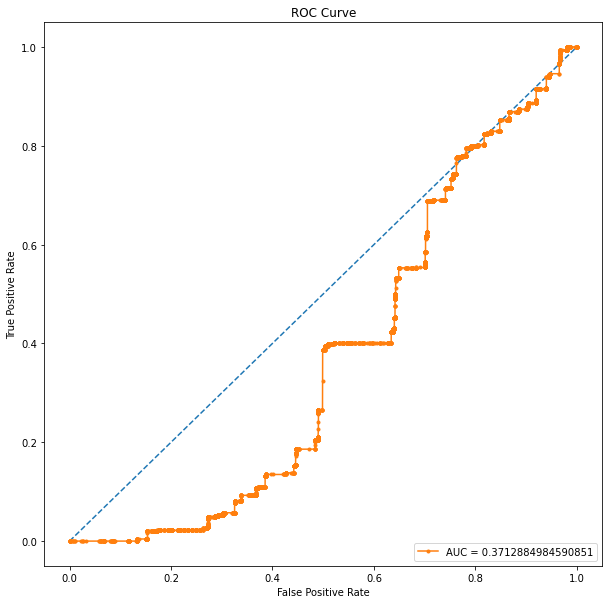

In [10]:
fpr, tpr, thresholds = roc_curve(y_true=test_y.astype(int), y_score=test_loss, pos_label=1)
auc = roc_auc_score(y_true=test_y.astype(int),  y_score=test_loss)
plt.figure(figsize=(10, 10))
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(fpr, tpr, marker=".", label=f"AUC = {auc}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")

ranked_thresholds = sorted(list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True)
attack_threshold = ranked_thresholds[0][1]
print(f"Attack Threshold: {attack_threshold}")

              precision    recall  f1-score   support

      benign       0.31      0.56      0.40    520379
      attack       0.31      0.14      0.19    733787

    accuracy                           0.31   1254166
   macro avg       0.31      0.35      0.30   1254166
weighted avg       0.31      0.31      0.28   1254166



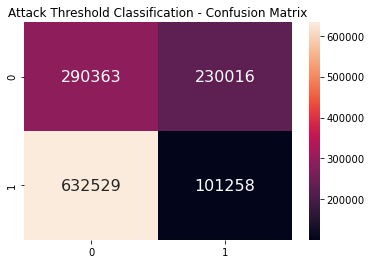

In [11]:
test_results = test_y.to_frame().astype(bool)
test_results['loss'] = pd.Series(test_loss, index=test_results.index)
test_results['is_attack_prediction'] = test_results.loss > attack_threshold

conf_matrix = confusion_matrix(test_results.is_attack, test_results.is_attack_prediction)
plt.figure()
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 16}, fmt='g')
plt.title('Attack Threshold Classification - Confusion Matrix')
print(classification_report(test_results.is_attack, test_results.is_attack_prediction, target_names=["benign", "attack"]))

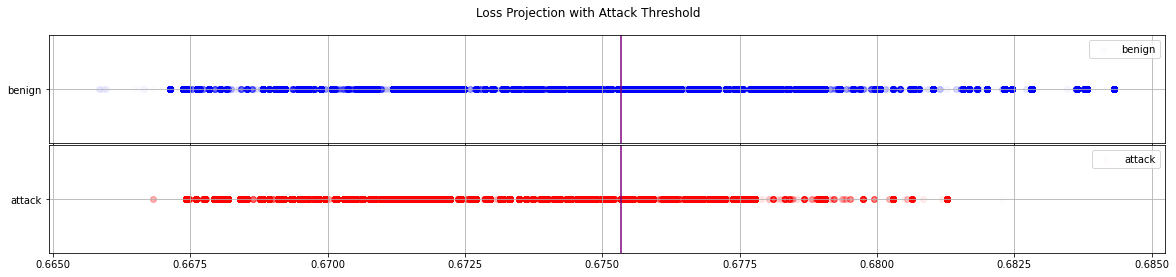

In [12]:
fig, (benign_ax, attack_ax) = plt.subplots(nrows=2, sharex=True, figsize=(20, 4))
fig.suptitle('Loss Projection with Attack Threshold')
fig.subplots_adjust(hspace=0.02)
attack_loss_points = [(i, 'attack') for i in test_results[test_results['is_attack'] == True].loss]
benign_loss_points = [(i, 'benign') for i in test_results[test_results['is_attack'] == False].loss]
benign_ax.scatter(*zip(*benign_loss_points), label="benign", color=['blue'], alpha=0.01)
attack_ax.scatter(*zip(*attack_loss_points), label="attack", color=['red'], alpha=0.01)
for ax in (benign_ax, attack_ax):
  ax.axvline(attack_threshold, 0.0, 10, color='purple')
  ax.legend()
  ax.grid(True)
plt.show()

Text(0.5, 1.0, 'Loss Distribution')

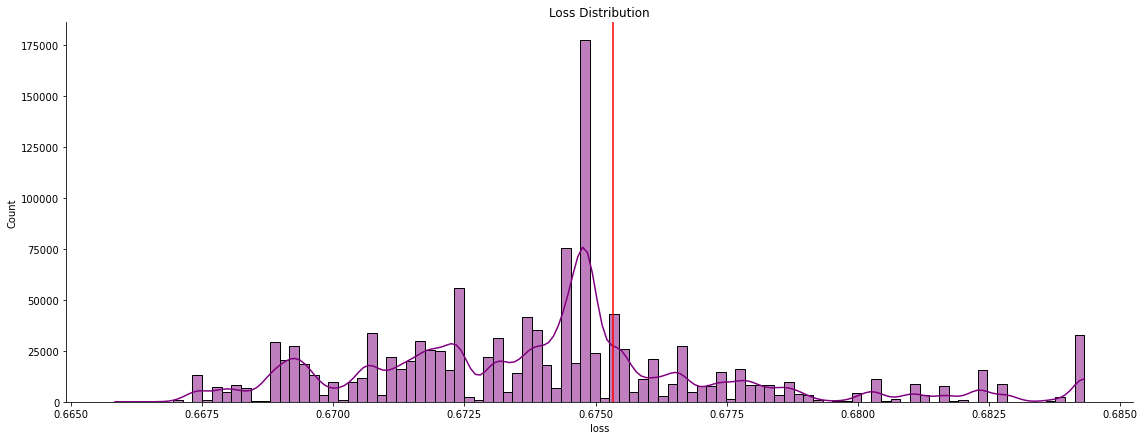

In [13]:
sns.displot(test_results.loss, bins=100, kde=True, color='purple', height=6, aspect=16/6)
plt.axvline(attack_threshold, 0.0, 10, color='r')
plt.title('Loss Distribution')